[View in Colaboratory](https://colab.research.google.com/github/hacertilbec/Protein-Classification/blob/master/Protein_Vectorization_Colab.ipynb)

In [1]:
!pip install biopython

In [0]:
from Bio import PDB
from Bio.PDB.Polypeptide import PPBuilder
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import os

In [16]:
from google.colab import files
uploaded = files.upload()

structures_A = [] # b.1.18.1 class

for pdb in uploaded.keys():
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb, pdb) 
    structures_A.append(structure)

Saving 1a02.pdb to 1a02 (4).pdb
Saving 1a3q.pdb to 1a3q (4).pdb
Saving 1gji.pdb to 1gji (4).pdb


/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5492.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5524.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5565.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5942.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4375.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4395.
  PDBConstru

In [17]:
uploaded2 = files.upload()

structures_B = [] # d.108.1.1 class

for pdb in uploaded2.keys():
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb, pdb) 
    structures_B.append(structure)

Saving 1m4d.pdb to 1m4d (2).pdb
Saving 1n71.pdb to 1n71 (2).pdb
Saving 1q2y.pdb to 1q2y (2).pdb


/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6349.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6397.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6445.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6513.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6566.
  PDBConstructionWarning)
/usr/local/lib/python2.7/dist-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6668.
  PDBConstru

In [0]:
protein_chain_dict = {"1m4d.pdb": "B", "1n71.pdb":"B", "1q2y.pdb":"A", "1a02.pdb":"N","1a3q.pdb":"B", "1gji.pdb": "B"}

### Aminoacid pair distance Matrix

In [0]:
def AminoacidPairDistanceMatrix(structure):
    aa_vectors = {} # aminoacid vector dictionary {aa_id: aa_carbon_coordinate} 

    aa_id = 0 # aminoacid id
    for model in structure:
        for chain in model:
          if chain.id == protein_chain_dict[str(structure.id)]:
            for residue in chain:
                try:
                    coords_CA = residue['CA'].coord # x,y,z coordinates of the C-alpha atom
                    aa_vectors[aa_id] = coords_CA
                except:
                    continue
                aa_id += 1

    aa_distance_matrix = [] # Aminoacid pair distance matrix
    for vec in aa_vectors.values():
        dist_vec = []
        for vec_ in aa_vectors.values():
            distance = np.linalg.norm(vec-vec_)
            dist_vec.append(distance)
        aa_distance_matrix.append(dist_vec)
        
    return np.array(aa_distance_matrix)

In [20]:
protein_matrix_dict = {}
for protein in structures_A:
    protein_matrix = AminoacidPairDistanceMatrix(protein)
    protein_matrix_dict[protein.id] = protein_matrix
    print protein.id, protein_matrix.shape

1a3q.pdb (285, 285)
1gji.pdb (275, 275)
1a02.pdb (280, 280)


In [21]:
for protein in structures_B:
    protein_matrix = AminoacidPairDistanceMatrix(protein)
    protein_matrix_dict[protein.id] = protein_matrix
    print protein.id, protein_matrix.shape

1n71.pdb (179, 179)
1m4d.pdb (176, 176)
1q2y.pdb (140, 140)


## Dimensionality Reduction with Autoencoders

In [0]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [0]:
def StackedAutoencoderWithTiedWeights(X_train, input_size, n_hidden1, n_hidden2):
    n_inputs = input_size 
    n_hidden1 = n_hidden1
    n_hidden2 =  n_hidden2 # codings
    n_hidden3 = n_hidden1 
    n_outputs = n_inputs

    learning_rate = 0.01
    l2_reg = 0.001

    activation = tf.nn.elu
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    initializer = tf.contrib.layers.variance_scaling_initializer()

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    keep_prob = tf.placeholder(tf.float32)

    weights1_init = initializer([n_inputs, n_hidden1])
    weights2_init = initializer([n_hidden1, n_hidden2])

    weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1") 
    weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2") 
    weights3 = tf.transpose(weights2, name="weights3") # tied weights
    weights4 = tf.transpose(weights1, name="weights4") # tied weights

    biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
    biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
    biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
    biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
    outputs = tf.matmul(hidden3, weights4) + biases4

    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = regularizer(weights1) + regularizer(weights2)

    loss = reconstruction_loss + reg_loss

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
    n_epochs = 5
    
    with tf.Session() as sess: 
        init.run() 
        for epoch in range(n_epochs):
            sess.run(training_op, feed_dict={X: X_train})
                
        features1 = hidden1.eval(feed_dict= {X: X_train})
        features2 = hidden2.eval(feed_dict= {X: X_train})
                
    return features1, features2

In [25]:
protein_features = {}
for protein, matrix in protein_matrix_dict.items():
    X_train = [np.array(matrix).flatten()]
    input_size = len(X_train[0])
    
    features1, features2 = StackedAutoencoderWithTiedWeights(X_train, input_size, 500, 2)
    protein_features[protein] = (features1, feature2)
    
    print protein, matrix.shape
    print len(features1[0]), len(features2[0]), "\n --------------------------------------------------------"

 1a3q.pdb (285, 285)
500 2 
 --------------------------------------------------------
1gji.pdb (275, 275)
500 2 
 --------------------------------------------------------
1a02.pdb (280, 280)
500 2 
 --------------------------------------------------------
1n71.pdb (179, 179)
500 2 
 --------------------------------------------------------
1m4d.pdb (176, 176)
500 2 
 --------------------------------------------------------
1q2y.pdb (140, 140)
500 2 
 --------------------------------------------------------


In [0]:
features1 = [f[0][0].tolist() for f in protein_features.values()]
features2 = [f[1][0].tolist() for f in protein_features.values()]

In [29]:
features2

[[-1.0, -1.0],
 [-1.0, -1.0],
 [-1.0, -1.0],
 [-1.0, -1.0],
 [-1.0, -1.0],
 [-1.0, -1.0]]

In [30]:
protein_features.keys()

[u'1a3q.pdb', u'1gji.pdb', u'1a02.pdb', u'1n71.pdb', u'1m4d.pdb', u'1q2y.pdb']

In [31]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features1)
features_2d

array([[ 758519.35000287, -350893.35114152],
       [ 243685.16942804,  717455.7472304 ],
       [-160230.49710704,  -95672.22073375],
       [-284547.62311698,  -87534.59964936],
       [-269602.73377531,  -92496.49577416],
       [-287823.66543157,  -90859.07993162]])

In [0]:
x = [f[0] for f in features_2d]
y = [f[1] for f in features_2d]

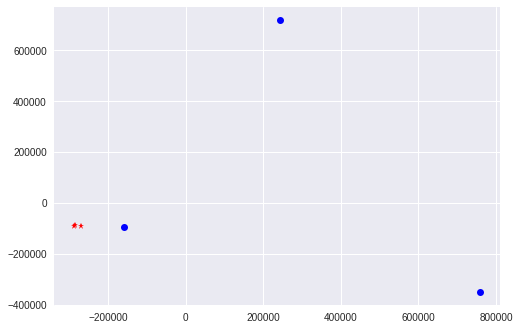

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x[:3], y[:3], 'ob')
ax.plot(x[3:], y[3:], '*r')

plt.show()